In [19]:
import re
import os
import numpy as np
import scipy.interpolate as interp
from scipy.ndimage import map_coordinates

from robotcar.python.camera_model import CameraModel
from robotcar.python.transform import build_se3_transform
from robotcar.python.image import load_image
from robotcar.python.interpolate_poses import interpolate_vo_poses, interpolate_ins_poses

from monodepth.utils.evaluation_utils import compute_errors

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cv2

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

### Directories

In [3]:
image_dir = '/media/psf/Data/Downloads/2014-12-05-11-09-10/2014-12-05-11-09-10_stereo_left_02/2014-12-05-11-09-10/stereo/left/'
extrinsics_dir = 'robotcar/extrinsics/'
models_dir = 'robotcar/models/'
lidar_dir = '/media/psf/Data/Downloads/2014-12-05-11-09-10/2014-12-05-11-09-10_ldmrs/ldmrs/'

vo_poses_file = '/media/psf/Data/Downloads/2014-12-05-11-09-10/2014-12-05-11-09-10_vo/vo/vo.csv'
ins_poses_file = '/media/psf/Data/Downloads/2014-12-05-11-09-10/2014-12-05-11-09-10_gps/gps/ins.csv'

#### Which image(s)

In [4]:
img_index = 10050

### Camera Extrinsics

In [5]:
model = CameraModel(models_dir, image_dir)

extrinsics_path = os.path.join(extrinsics_dir, model.camera + '.txt')
with open(extrinsics_path) as extrinsics_file:
    extrinsics = [float(x) for x in next(extrinsics_file).split(' ')]

G_camera_vehicle = build_se3_transform(extrinsics)

### Build Pointclouds for VO and INS

In [6]:
# Timestamps for Pointcloud Generation
# start_time = 1418381798113072
# end_time = 1418381817070979

# micro!!s history for pointcloud generation
time_minus = 10000000
time_plus = 0

### Process Image(s)

In [7]:
timestamps_path = os.path.join(image_dir, os.pardir, model.camera + '.timestamps')
if not os.path.isfile(timestamps_path):
    timestamps_path = os.path.join(image_dir, os.pardir, os.pardir, model.camera + '.timestamps')

with open(timestamps_path) as timestamps_file:
    for i, line in enumerate(timestamps_file):
        if i == img_index:
            timestamp_img = int(line.split(' ')[0])
            
image_path = os.path.join(image_dir, str(timestamp_img) + '.png')
image = load_image(image_path, model)
print(image_path)

/media/psf/Data/Downloads/2014-12-05-11-09-10/2014-12-05-11-09-10_stereo_left_02/2014-12-05-11-09-10/stereo/left/1417778437891432.png


In [8]:
lidar = re.search('(lms_front|lms_rear|ldmrs)', lidar_dir).group(0)
timestamps_path = os.path.join(lidar_dir, os.pardir, lidar + '.timestamps')

timestamps = []
with open(timestamps_path) as timestamps_file:
    for line in timestamps_file:
        timestamp = int(line.split(' ')[0])
        if (timestamp_img-time_minus) <= timestamp <= (timestamp_img+time_plus):
            timestamps.append(timestamp)

print(len(timestamps), "LIDAR Scans found")
            
if len(timestamps) == 0:
    raise ValueError("No LIDAR data in the given time bracket.")

(125, 'LIDAR Scans found')


### Lidar Extrinsics

In [9]:
with open(os.path.join(extrinsics_dir, lidar + '.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
G_posesource_laser = build_se3_transform([float(x) for x in extrinsics.split(' ')])

#### VO Pointcloud

In [10]:
# sensor is VO, which is located at the main vehicle frame
poses = interpolate_vo_poses(vo_poses_file, timestamps, timestamp_img)

pointcloud_vo = np.array([[0], [0], [0], [0]])

for i in range(0, len(poses)):
    scan_path = os.path.join(lidar_dir, str(timestamps[i]) + '.bin')
    if not os.path.isfile(scan_path):
        continue

    scan_file = open(scan_path)
    scan = np.fromfile(scan_file, np.double)
    scan_file.close()
    scan = scan.reshape((len(scan) // 3, 3)).transpose()
    scan = np.dot(np.dot(poses[i], G_posesource_laser), np.vstack([scan, np.ones((1, scan.shape[1]))]))
    pointcloud_vo = np.hstack([pointcloud_vo, scan])

pointcloud_vo = pointcloud_vo[:, 1:]
pointcloud_vo = np.dot(G_camera_vehicle, pointcloud_vo)

robotcar/python/interpolate_poses.py:141: RuntimeWarning: divide by zero encountered in divide
  (pose_timestamps[upper_indices] - pose_timestamps[lower_indices])


#### GPS INS Pointcloud

In [11]:
with open(os.path.join(extrinsics_dir, 'ins.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
    G_posesource_laser = np.linalg.solve(build_se3_transform([float(x) for x in extrinsics.split(' ')]),
                                         G_posesource_laser)
    G_camera_posesource = G_camera_vehicle * build_se3_transform([float(x) for x in extrinsics.split(' ')])
    
poses = interpolate_ins_poses(ins_poses_file, timestamps, timestamp_img)

pointcloud_ins = np.array([[0], [0], [0], [0]])

for i in range(0, len(poses)):
    scan_path = os.path.join(lidar_dir, str(timestamps[i]) + '.bin')
    if not os.path.isfile(scan_path):
        continue

    scan_file = open(scan_path)
    scan = np.fromfile(scan_file, np.double)
    scan_file.close()
    scan = scan.reshape((len(scan) // 3, 3)).transpose()
    scan = np.dot(np.dot(poses[i], G_posesource_laser), np.vstack([scan, np.ones((1, scan.shape[1]))]))
    pointcloud_ins = np.hstack([pointcloud_ins, scan])

pointcloud_ins = pointcloud_ins[:, 1:]
pointcloud_ins = np.dot(G_camera_posesource, pointcloud_ins)

#### Sparse Local Pointcloud

In [12]:
lidar = re.search('(lms_front|lms_rear|ldmrs)', lidar_dir).group(0)
timestamps_path = os.path.join(lidar_dir, os.pardir, lidar + '.timestamps')

#timestamps = []
with open(timestamps_path) as timestamps_file:
    for line in timestamps_file:
        this_timestamp = int(line.split(' ')[0])
        if this_timestamp >= timestamp_img:
            timestamp_lidar = this_timestamp
            break

            
            
with open(os.path.join(extrinsics_dir, lidar + '.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
G_posesource_laser = build_se3_transform([float(x) for x in extrinsics.split(' ')])

local_pointcloud = np.array([[0], [0], [0], [0]])

scan_path = os.path.join(lidar_dir, str(timestamp_lidar) + '.bin')

scan_file = open(scan_path)
scan = np.fromfile(scan_file, np.double)
scan_file.close()

scan = scan.reshape((len(scan) // 3, 3)).transpose()

scan = np.dot(G_posesource_laser, np.vstack([scan, np.ones((1, scan.shape[1]))]))
local_pointcloud = np.hstack([local_pointcloud, scan])

local_pointcloud = local_pointcloud[:, 1:]
local_pointcloud = np.dot(G_camera_vehicle, local_pointcloud)

## Project Pointclouds

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/home/parallels/.local/lib/python2.7/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/parallels/.local/lib/python2.7/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: Matpl

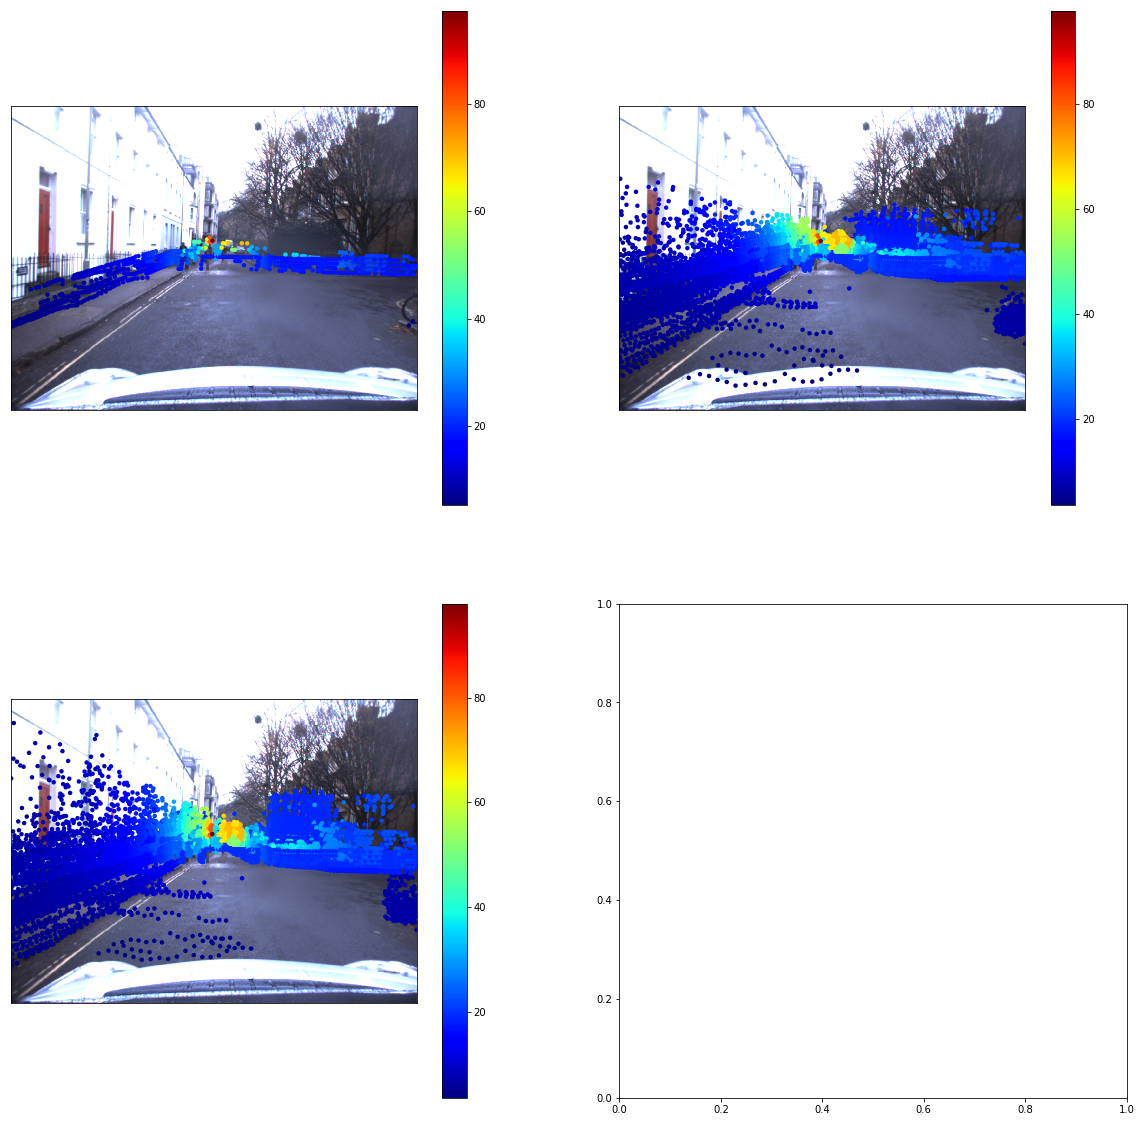

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

plt.subplot(2, 2, 1)
uv, depth = model.project(local_pointcloud, image.shape)
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=depth, edgecolors='none', cmap='jet')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 2)
uv, depth = model.project(pointcloud_vo, image.shape)
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=depth, edgecolors='none', cmap='jet')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 3)
uv, depth = model.project(pointcloud_ins, image.shape)
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=depth, edgecolors='none', cmap='jet')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])
plt.show()



## Get Prediction

In [14]:
img = load_image(image_path)
img = Image.fromarray(img)
img.save("test_images/test.png")

In [15]:
!python monodepth/monodepth_simple.py --image_path test_images/test.png --checkpoint_path monodepth/model_kitti/model_kitti.ckpt

2018-02-12 18:02:07.378879: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
done!


In [16]:
pred_disparities = np.load('test_images/test_disp.npy')

def convert_disps_to_depths(pred_disp, height, width):

    pred_disp = width * cv2.resize(pred_disp, (width, height), interpolation=cv2.INTER_LINEAR)

    pred_depths = 983.044006 * 0.24 / pred_disp
    
    return pred_depths
pred_depth = convert_disps_to_depths(pred_disparities, 960, 1280)

## Show Error Magnitude

In [17]:
%matplotlib qt4
import warnings
warnings.filterwarnings('ignore')

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,20))

# Sparse Map
ax = plt.subplot(3, 2, 1)
ax.set_title("Local PC - Pred Error (m) [Pred - GT]", fontsize=16)
uv, depth = model.project(local_pointcloud, image.shape)

uv = np.array(uv)
depth = np.array(depth)
mask = ((uv[0,:] < 1279) & (uv[1,:] < 959) & (depth < 80))
depth = depth[mask]
uv = uv[:, mask]

gt_img = np.zeros((960, 1280))
coords = uv.transpose().astype(int)
gt_img[coords[:,1],coords[:,0]] = depth
compute_errors(gt_img[gt_img != 0], pred_depth[gt_img != 0])
abs_rel, sq_rel, rms, log_rms, a1, a2, a3 = compute_errors(gt_img[gt_img != 0], pred_depth[gt_img != 0])
print("Errors for Local LIDAR:")
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'a1', 'a2', 'a3'))
print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), a1.mean(), a2.mean(), a3.mean()))

pixels = uv.transpose()
# 1200 x 960
pred_depth_pixels = []
pred_depth_error = []
i = 0
for pixel in pixels:
    # Sparse
    pred_depth_pixels.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))])
    pred_depth_error.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))] - depth[i])
    i += 1

# Limit coordinates to image size
pred_depth_pixels = np.array(pred_depth_pixels)
pred_depth_error = np.array(pred_depth_error)
mask = (pred_depth_pixels < 80)
depth = depth[mask]
uv = uv[:, mask]
pred_depth_error = pred_depth_error[mask]
pred_depth_pixels = pred_depth_pixels[mask]
    
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=pred_depth_error,
                 edgecolors='none', norm=MidpointNormalize(midpoint=0.) , cmap='RdYlGn')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(3, 2, 2)
ax.set_title("Local PC - Pred Error (Abs. Mag.) [Pred - GT]", fontsize=16)
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=np.abs(pred_depth_error/depth),
                 edgecolors='none', cmap='Reds')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(3, 2, 3)
ax.set_title("VO PC - Pred Error (m) [Pred - GT]", fontsize=16)
uv, depth = model.project(pointcloud_vo, image.shape)

# Limit coordinates to image size
uv = np.array(uv)
depth = np.array(depth)
mask = ((uv[0,:] < 1279) & (uv[1,:] < 959) & (depth < 80))
depth = depth[mask]
uv = uv[:, mask]

gt_img = np.zeros((960, 1280))
coords = uv.transpose().astype(int)
gt_img[coords[:,1],coords[:,0]] = depth
compute_errors(gt_img[gt_img != 0], pred_depth[gt_img != 0])
abs_rel, sq_rel, rms, log_rms, a1, a2, a3 = compute_errors(gt_img[gt_img != 0], pred_depth[gt_img != 0])
print("Errors for INS LIDAR:")
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'a1', 'a2', 'a3'))
print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), a1.mean(), a2.mean(), a3.mean()))

pixels = uv.transpose()
# 1200 x 960
pred_depth_pixels = []
pred_depth_error = []
i = 0
for pixel in pixels:
    # Sparse
    pred_depth_pixels.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))])
    pred_depth_error.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))] - depth[i])
    i += 1

# Limit coordinates to image size
pred_depth_pixels = np.array(pred_depth_pixels)
pred_depth_error = np.array(pred_depth_error)
mask = (pred_depth_pixels < 80)
depth = depth[mask]
uv = uv[:, mask]
pred_depth_error = pred_depth_error[mask]
pred_depth_pixels = pred_depth_pixels[mask]
    
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=pred_depth_error, norm=MidpointNormalize(midpoint=0.), cmap='RdYlGn',
                 edgecolors='none')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(3, 2, 4)
ax.set_title("VO PC - Pred Error (Abs. Mag.) [Pred - GT]", fontsize=16)
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=np.abs(pred_depth_error/depth),
                 edgecolors='none', cmap='Reds')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(3, 2, 5)
ax.set_title("INS PC - Pred Error (m) [Pred - GT]", fontsize=16)
uv, depth = model.project(pointcloud_ins, image.shape)

# Limit coordinates to image size
uv = np.array(uv)
depth = np.array(depth)
mask = ((uv[0,:] < 1279) & (uv[1,:] < 959) & (depth < 80))
depth = depth[mask]
uv = uv[:, mask]

gt_img = np.zeros((960, 1280))
coords = uv.transpose().astype(int)
gt_img[coords[:,1],coords[:,0]] = depth
compute_errors(gt_img[gt_img != 0], pred_depth[gt_img != 0])
abs_rel, sq_rel, rms, log_rms, a1, a2, a3 = compute_errors(gt_img[gt_img != 0], pred_depth[gt_img != 0])
print("Errors for VO LIDAR:")
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'a1', 'a2', 'a3'))
print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), a1.mean(), a2.mean(), a3.mean()))

pixels = uv.transpose()
# 1200 x 960
pred_depth_pixels = []
pred_depth_error = []
i = 0
for pixel in pixels:
    # Sparse
    pred_depth_pixels.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))])
    pred_depth_error.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))] - depth[i])
    i += 1

# Limit coordinates to image size
pred_depth_pixels = np.array(pred_depth_pixels)
pred_depth_error = np.array(pred_depth_error)
mask = (pred_depth_pixels < 80)
depth = depth[mask]
uv = uv[:, mask]
pred_depth_error = pred_depth_error[mask]
pred_depth_pixels = pred_depth_pixels[mask]
    
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=pred_depth_error, edgecolors='none', norm=MidpointNormalize(midpoint=0.), cmap='RdYlGn')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

ax = plt.subplot(3, 2, 6)
ax.set_title("INS PC - Pred Error (Abs. Mag.) [Pred - GT]", fontsize=16)
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=np.abs(pred_depth_error/depth),
                 edgecolors='none', cmap='Reds')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])

plt.show()

Errors for Local LIDAR:
   abs_rel,     sq_rel,        rms,    log_rms,         a1,         a2,         a3
    0.2544,     2.7854,      8.454,      0.415,      0.491,      0.722,      0.888
Errors for INS LIDAR:
   abs_rel,     sq_rel,        rms,    log_rms,         a1,         a2,         a3
    0.2707,     3.7635,     10.435,      0.387,      0.480,      0.770,      0.912
Errors for VO LIDAR:
   abs_rel,     sq_rel,        rms,    log_rms,         a1,         a2,         a3
    0.2843,     4.8101,     11.677,      0.394,      0.487,      0.772,      0.911
